In [1]:
from pathlib import Path
import itertools
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import Datasets.ModelData as md
from session import *
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
from validation import _AccuracyMeter
from LR_Schedule.cos_anneal import CosAnneal
import matplotlib.pyplot as plt
import arff

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
idtohand = {0: "Nothing in hand; not a recognized poker hand",
            1: "One pair; one pair of equal ranks within five cards",
            2: "Two pairs; two pairs of equal ranks within five cards",
            3: "Three of a kind; three equal ranks within five cards",
            4: "Straight; five cards, sequentially ranked with no gaps",
            5: "Flush; five cards with the same suit",
            6: "Full house; pair + different rank three of a kind",
            7: "Four of a kind; four equal ranks within five cards",
            8: "Straight flush; straight + flush",
            9: "Royal flush; {Ace, King, Queen, Jack, Ten} + flush" }

num_classes = 10

idtosuit = {0: "Hearts", 1: "Spades", 2: "Diamonds", 3: "Clubs"}
idtorank = {0: "Ace", 
            1: "2", 
            2: "3", 
            3: "4", 
            4: "5", 
            5: "6", 
            6: "7", 
            7: "8", 
            8: "9", 
            9: "10", 
            10: "Jack", 
            11: "Queen", 
            12: "King"}

In [11]:
class PokerHandDataset(Dataset):
    def __init__(self, file, tfm=None, percentage=1, balanced=False):
        self.hands, self.labels = self.parse_csv(file, percentage)
        self.tfm = tfm
        
                
        if balanced:
            counts = np.zeros(num_classes)

            for label in self.labels:
                counts[label] += 1

            class_weights = len(self.labels) / counts

            instance_weights = np.zeros(len(self.labels))

            for idx, label in enumerate(self.labels):
                instance_weights[idx] = class_weights[label]

            self.sampler = torch.utils.data.sampler.WeightedRandomSampler(instance_weights, len(instance_weights))
        else:
            self.sampler = None
       
    @staticmethod
    def parse_csv(file, percentage=1):
        df = pd.read_csv(file, header=None)
        xs = df[df.columns[0:10]]
        labels = np.array(df[df.columns[-1]])
        
        hands = []
        for hand in xs.values:
            hand = np.array(hand).reshape((5,2)) - 1
            hand = hand[hand[:,1].argsort()]
            hands.append(hand)
            
        hands = np.array(hands)
        
        if percentage < 1:
            idxs = np.random.choice(len(xs), int(len(xs) * percentage), replace=False)
            hands = hands[idxs]
            labels = labels[idxs]
            
        return hands, labels
        
    @staticmethod
    def make_tensor(hand):
        hand_tensor = torch.zeros((4,13)) - 1
        for card in hand:       
            hand_tensor[card[0], card[1]] = 1
        return hand_tensor.unsqueeze(0)
    
    @staticmethod
    def make_one_hot(label):
        tensor = torch.zeros(10)
        tensor[label] = 1
        return tensor
    
    def save_arff(self, file_name):
        data = np.concatenate((self.hands.reshape((-1, 10)), self.labels.reshape(-1, 1)), 1)
        
        cols = ["SuitCard1", "RankCard1", 
                "SuitCard2", "RankCard2", 
                "SuitCard3", "RankCard3", 
                "SuitCard4", "RankCard4",
                "SuitCard5", "RankCard5",
                "Hand"]

        df = pd.DataFrame(data, columns=cols)

        arff.dump(file_name, df.values, names=df.columns)
        
    
    def __len__(self): return len(self.hands)

    def __getitem__(self, i):
        hand, label = self.hands[i], self.labels[i]
        x, y = self.make_tensor(hand), self.make_one_hot(label)
        
        if self.tfm is not None:
            x = self.tfm.transform_x(x)
            
            
        return x, y

In [12]:
class SuitShiftTransform():
    def transform_x(self, hand):
        return hand[:,torch.randperm(4)]

In [15]:
data_path = Path("./Datasets/PokerHands")
train_dataset = PokerHandDataset(data_path/'training.csv')
val_dataset = PokerHandDataset(data_path/'testing.csv', percentage=.05)
test_dataset = PokerHandDataset(data_path/'testing.csv')

In [16]:
# train_dataset.save_arff('./Datasets/PokerHands/training_sorted.arff')
# test_dataset.save_arff('./Datasets/PokerHands/testing_sorted.arff')

In [16]:
data = md.ModelData({'train': train_dataset}, 8)
val_data = md.ModelData({'val': val_dataset, 'test': test_dataset}, 256)

In [17]:
class Network(nn.Module):
    def __init__(self):
        super().__init__();
        self.conv1 = nn.Conv2d(1, 8, (4,1))       
        self.conv2 = nn.Conv2d(1, 8, (1,13))
        self.relu1 = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(p=.5)
        self.fc1 = nn.Linear(8*4 + 8*13, num_classes)
        # self.relu2 = nn.ReLU(inplace=True)
        # self.fc2 = nn.Linear(100, num_classes)
        
    def forward(self, x):
        x_1 = self.conv1(x)
        x_2 = self.conv2(x)
        x = torch.cat([x_1.view(x_1.size(0), -1), x_2.view(x_2.size(0), -1)], dim=1)
        x = self.drop(x)
        x = self.relu1(x)
        x = self.fc1(x)
        # x = self.relu2(x)
        # x = self.fc2(x)
        return F.softmax(x, dim=1)

model = Network()

In [18]:
class FocalLoss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, label):
        weight = self.get_weight(pred, label)
        return F.binary_cross_entropy_with_logits(pred, label, weight)
    
    def get_weight(self, x, t):
        alpha, gamma = 0.25, 2
        p = x
        pt = p * t + (1-p) * (1-t)
        w = alpha * t + (1-alpha) * (1-t)
        return w * (1-pt).pow(gamma)

In [19]:
class PokerHandAccuracy(_AccuracyMeter):
    def __init__(self):
        self.reset()
        self.confusion = [[0 for y in range(num_classes)] for x in range(num_classes)]

    def reset(self):
        self.num_correct = 0
        self.count = 0
        self.confusion = [[0 for y in range(num_classes)] for x in range(num_classes)]
        
    def accuracy(self): 
        return self.num_correct / self.count

    def update(self, actn, label, log=False):   
        # outputs = torch.sigmoid(actn)
        # if log: print("Actn : ", outputs)
        vals, preds = torch.max(actn, 1)
        # preds = preds + 1
        if log: print("Max  :", preds)
        # bgs = vals < .7
        # if log: print("BGS  : ", bgs)
        # preds[bgs] = 0
        if log: print("Preds: ", preds)
        _, gt = torch.max(label, 1)     
        if log: print("GT   : ", gt)
        self.num_correct += torch.sum(preds == gt).item()
        if log: print("Num Correct: ", self.num_correct)
        self.count += label.shape[0]
        
        for lab, pred in zip(gt, preds):
            self.confusion[lab][pred] += 1
            
    def plot_confusion_matrix(self,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
        cm = np.array(self.confusion)
        fig, ax = plt.subplots(figsize=(12,12))
        img = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.colorbar(img, ax=ax)
        ax.set_title(title)
        tick_marks = np.arange(num_classes)
        plt.xticks(tick_marks, rotation=45)
        plt.yticks(tick_marks)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')

In [20]:
criterion = nn.BCELoss()
optim_fn = optim.Adam
sess = Session(model, criterion, optim_fn, 1e-2)

In [21]:
x, y = next(iter(data['train']))
x

tensor([[[[ 1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]]],


        [[[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [ 1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]]],


        [[[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [ 1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]]],


        [[[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.

In [22]:
actn = sess.forward(x)
actn

tensor([[0.2121, 0.0399, 0.0665, 0.1375, 0.0931, 0.0847, 0.1542, 0.0452, 0.1017,
         0.0650],
        [0.1540, 0.0985, 0.0948, 0.0821, 0.0677, 0.0627, 0.1943, 0.0548, 0.1197,
         0.0714],
        [0.2282, 0.0618, 0.0390, 0.1323, 0.1854, 0.0517, 0.0482, 0.0657, 0.0991,
         0.0886],
        [0.1587, 0.0978, 0.0236, 0.1383, 0.0909, 0.0622, 0.1506, 0.0602, 0.0458,
         0.1721],
        [0.0994, 0.0953, 0.0642, 0.0899, 0.1039, 0.1115, 0.1315, 0.1441, 0.1018,
         0.0583],
        [0.0938, 0.0760, 0.0803, 0.0953, 0.0394, 0.0648, 0.1578, 0.1206, 0.1938,
         0.0783],
        [0.2121, 0.0349, 0.0471, 0.1771, 0.0712, 0.0452, 0.0763, 0.1329, 0.1317,
         0.0715],
        [0.1943, 0.0619, 0.0270, 0.1465, 0.1265, 0.0369, 0.2233, 0.0620, 0.0374,
         0.0842]], grad_fn=<SoftmaxBackward>)

In [23]:
accuracy = PokerHandAccuracy()
accuracy.update(actn, y, log=True)

Max  : tensor([0, 6, 0, 9, 7, 8, 0, 6])
Preds:  tensor([0, 6, 0, 9, 7, 8, 0, 6])
GT   :  tensor([9, 9, 9, 9, 9, 8, 8, 8])
Num Correct:  2


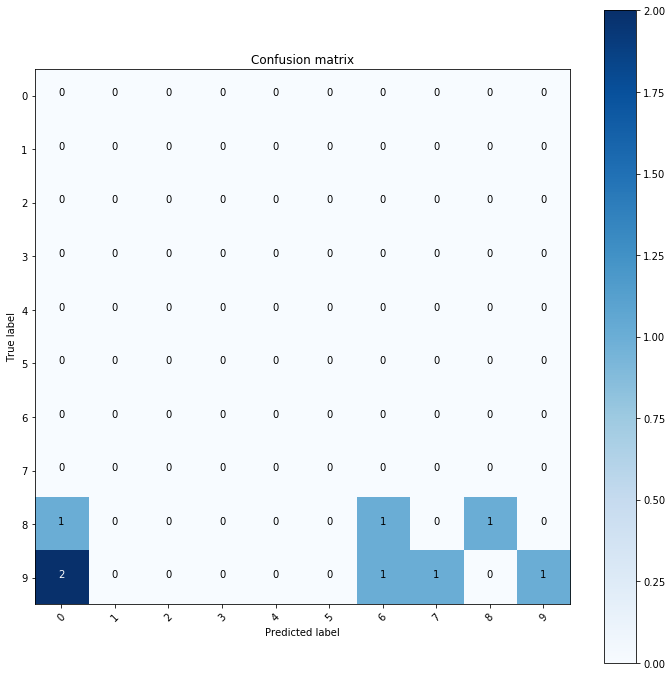

In [26]:
accuracy.plot_confusion_matrix()

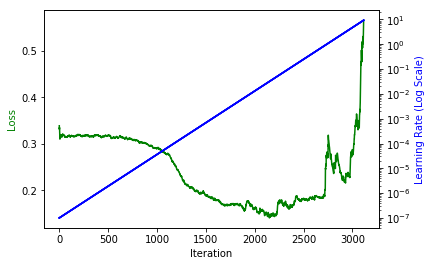

In [25]:
lr_find(sess, data['train'], start_lr=1e-7)

In [27]:
sess.set_lr(1e-4)

In [28]:
accuracy = PokerHandAccuracy()
validator = Validator(val_data['val'], accuracy)
lr_schedule = CosAnneal(len(data['train']), lr_min=1e-5, T_mult=2)
schedule = TrainingSchedule(data['train'], [lr_schedule, validator])

In [29]:
sess.train(schedule, 32)

Training Loss: 0.177890  Validaton Loss: 0.172740 Validation Accuracy: 0.515900


Training Loss: 0.175619  Validaton Loss: 0.169521 Validation Accuracy: 0.541160


Training Loss: 0.173803  Validaton Loss: 0.168182 Validation Accuracy: 0.558220


Training Loss: 0.167491  Validaton Loss: 0.162327 Validation Accuracy: 0.640780


Training Loss: 0.163470  Validaton Loss: 0.157365 Validation Accuracy: 0.712860


Training Loss: 0.160828  Validaton Loss: 0.154717 Validation Accuracy: 0.720220


Training Loss: 0.161851  Validaton Loss: 0.153725 Validation Accuracy: 0.720520


Training Loss: 0.153846  Validaton Loss: 0.147163 Validation Accuracy: 0.722520


Training Loss: 0.153116  Validaton Loss: 0.141176 Validation Accuracy: 0.743800


Training Loss: 0.148255  Validaton Loss: 0.136285 Validation Accuracy: 0.759400


Training Loss: 0.144347  Validaton Loss: 0.131427 Validation Accuracy: 0.797920


Training Loss: 0.142700  Validaton Loss: 0.127476 Validation Accuracy: 0.812340


Training Loss: 0.138924  Validaton Loss: 0.124963 Validation Accuracy: 0.825160


Training Loss: 0.135524  Validaton Loss: 0.123652 Validation Accuracy: 0.849920


Training Loss: 0.134257  Validaton Loss: 0.122768 Validation Accuracy: 0.855480


Training Loss: 0.133355  Validaton Loss: 0.116107 Validation Accuracy: 0.862720


Training Loss: 0.135920  Validaton Loss: 0.111131 Validation Accuracy: 0.913580


Training Loss: 0.126709  Validaton Loss: 0.106139 Validation Accuracy: 0.916720


Training Loss: 0.119461  Validaton Loss: 0.101716 Validation Accuracy: 0.923560


Training Loss: 0.120874  Validaton Loss: 0.097914 Validation Accuracy: 0.923880


Training Loss: 0.120655  Validaton Loss: 0.095161 Validation Accuracy: 0.924120


Training Loss: 0.123782  Validaton Loss: 0.093267 Validation Accuracy: 0.924120


Training Loss: 0.123791  Validaton Loss: 0.091097 Validation Accuracy: 0.924120


Training Loss: 0.119536  Validaton Loss: 0.089718 Validation Accuracy: 0.924120


Training Loss: 0.121623  Validaton Loss: 0.088514 Validation Accuracy: 0.924120


Training Loss: 0.117433  Validaton Loss: 0.087058 Validation Accuracy: 0.924120


Training Loss: 0.115813  Validaton Loss: 0.086477 Validation Accuracy: 0.924120


Training Loss: 0.117053  Validaton Loss: 0.085807 Validation Accuracy: 0.924120


Training Loss: 0.119587  Validaton Loss: 0.085374 Validation Accuracy: 0.924120


Training Loss: 0.118243  Validaton Loss: 0.085027 Validation Accuracy: 0.924120


Training Loss: 0.112237  Validaton Loss: 0.084766 Validation Accuracy: 0.924120


Training Loss: 0.115347  Validaton Loss: 0.081952 Validation Accuracy: 0.924120



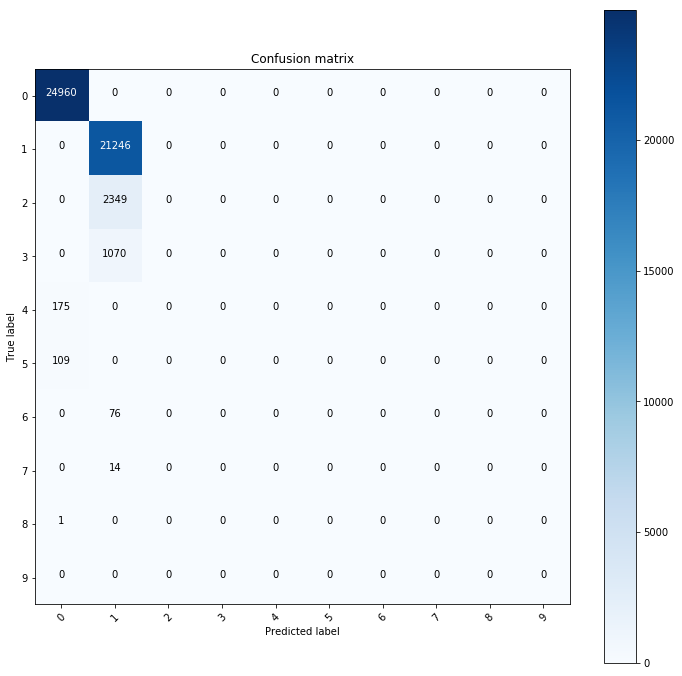

In [30]:
accuracy.plot_confusion_matrix()

In [ ]:
lr_schedule.plot()

In [ ]:
sess.save("PokerHand-99.6")

Training Loss: 0.000000  Validaton Loss: 0.081483 Validation Accuracy: 0.923311


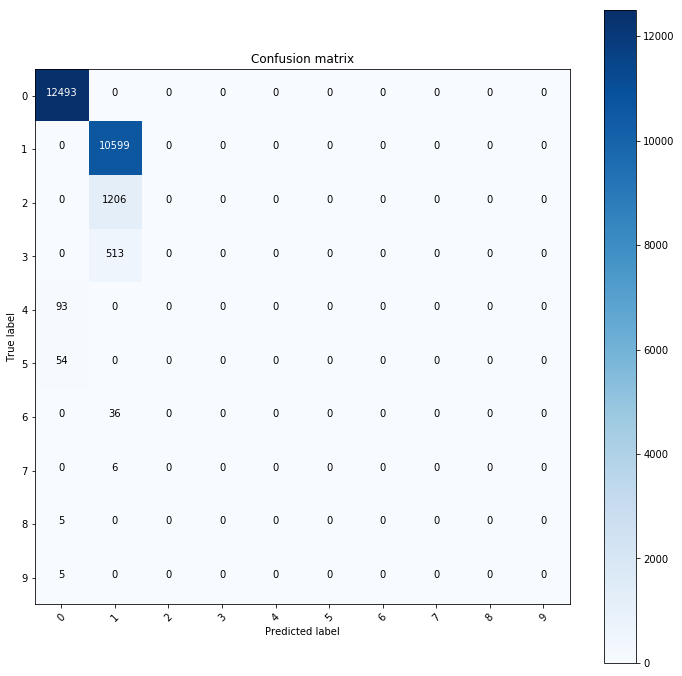

In [31]:
t_accuracy = PokerHandAccuracy()
t_validator = Validator(data['train'], t_accuracy)
t_validator.on_epoch_end(sess, LossMeter())
t_accuracy.plot_confusion_matrix()

Training Loss: 0.000000  Validaton Loss: 0.082002 Validation Accuracy: 0.923707


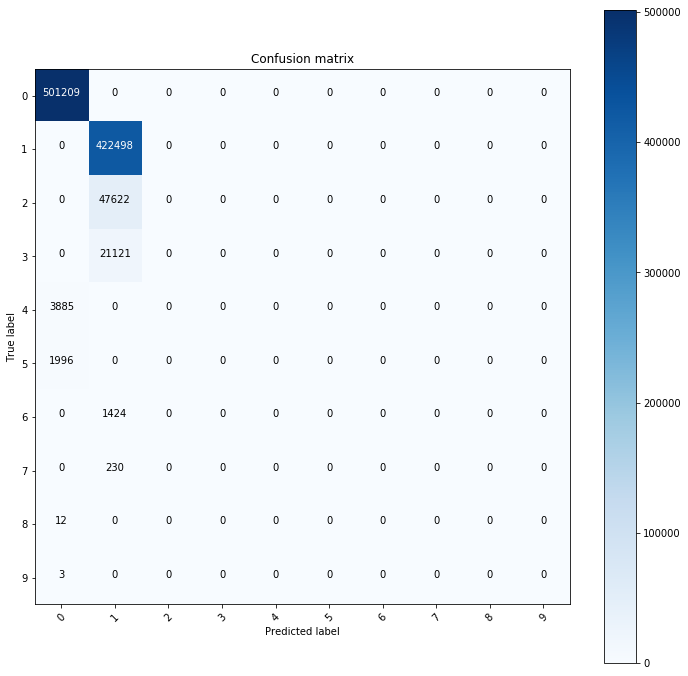

In [32]:
t_accuracy = PokerHandAccuracy()
t_validator = Validator(val_data['test'], t_accuracy)
t_validator.on_epoch_end(sess, LossMeter())
t_accuracy.plot_confusion_matrix()

In [ ]:
len(data['train'])

In [ ]:
len(data['test'])